In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

2.8.0+cu126
2.8.0+cpu


In [2]:
torch.random.manual_seed(100)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [3]:
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

SPEECH_FILE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")

C:\Users\adewo\AppData\Local\Temp\ipykernel_3016\499805210.py:5: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  SPEECH_FILE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")


#### Create a pipeline

In [4]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
print("Sample Rate:", bundle.sample_rate)
print("Labels: ", bundle.get_labels())

Sample Rate: 16000
Labels:  ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [5]:
model = bundle.get_model().to(device)
model

Wav2Vec2Model(
  (feature_extractor): FeatureExtractor(
    (conv_layers): ModuleList(
      (0): ConvLayerBlock(
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      )
      (1-4): 4 x ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (5-6): 2 x ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      )
    )
  )
  (encoder): Encoder(
    (feature_projection): FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (pos_conv_embed): ConvolutionalPositionalEmbedding(
        (conv): ParametrizedConv1d(
          768, 768, kernel_size=(128,), stride=(1,), padding=(64,), groups=16
          (parametriza

### Load data

In [6]:
IPython.display.Audio(SPEECH_FILE)

In [7]:
print(str(torchaudio.list_audio_backends()))

['soundfile']


C:\Users\adewo\AppData\Local\Temp\ipykernel_3016\2458030327.py:1: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  print(str(torchaudio.list_audio_backends()))


In [8]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

# If sample rate does not align with what we expect, we resample using torchaudio.functional.resample
if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

c:\Users\adewo\.conda\envs\pytorch_env\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


### Acoustic Feature Extraction

In [9]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

In [10]:
features

[tensor([[[ 0.1649,  0.2176,  0.0993,  ...,  0.3318,  0.0641,  0.0393],
          [ 0.1101,  0.0955,  0.0116,  ...,  0.4119, -0.0303,  0.0518],
          [-0.0709,  0.1380, -0.0045,  ...,  0.5973, -0.0263,  0.1750],
          ...,
          [-0.1441, -0.1851, -0.0425,  ...,  0.4558,  0.1976,  0.1106],
          [ 0.0929,  0.0386,  0.2404,  ...,  0.0550, -0.1844, -0.2647],
          [ 0.4033,  0.0617, -0.0814,  ..., -0.0870, -0.0457, -0.1930]]],
        device='cuda:0'),
 tensor([[[ 0.2421, -0.1542,  0.0445,  ...,  0.2425,  0.0663,  0.0524],
          [ 0.2178, -0.1804, -0.1847,  ...,  0.4040,  0.0467,  0.0768],
          [ 0.1052, -0.1536, -0.3267,  ...,  0.6410,  0.0248,  0.1306],
          ...,
          [ 0.3346, -0.2729, -0.0633,  ...,  0.6496, -0.0886, -0.0363],
          [ 0.3577, -0.3867, -0.0862,  ...,  0.2462,  0.0859, -0.0335],
          [ 0.2619, -0.0295, -0.0057,  ..., -0.1740, -0.1245, -0.1171]]],
        device='cuda:0'),
 tensor([[[ 0.2829, -0.3029,  0.1391,  ...,  0.068

In [11]:
len(features)

12

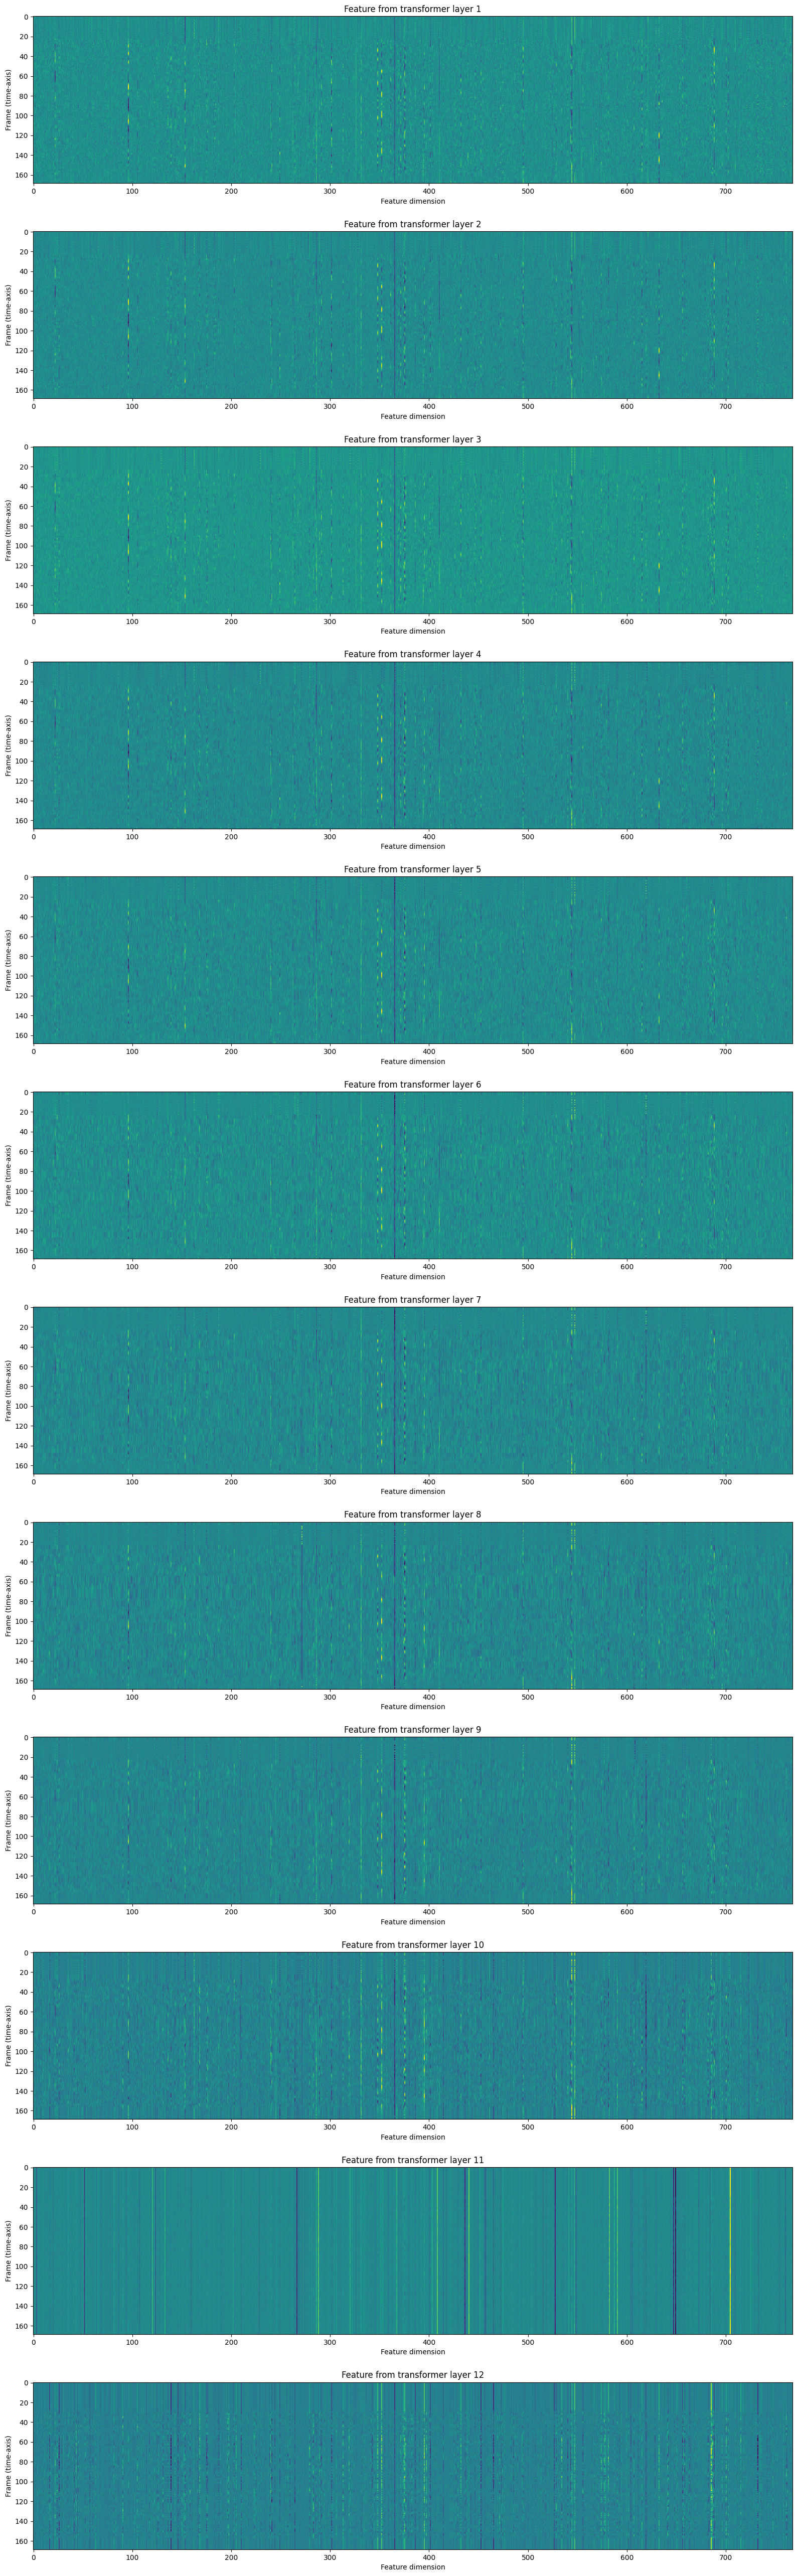

In [12]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3*len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation='nearest')
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

#### Feature Classification

Class labels:  ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


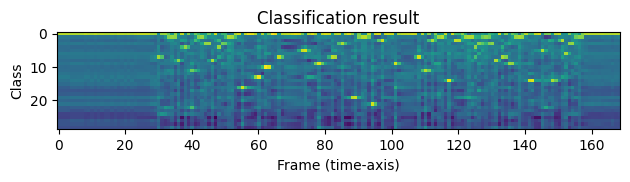

In [13]:
with torch.inference_mode():
    emission, _ = model(waveform)



plt.imshow(emission[0].cpu().T, interpolation='nearest')
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels: ", bundle.get_labels())

### Generate Transcripts

In [14]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])
    
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

print(transcript)
IPython.display.Audio(SPEECH_FILE)

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|
